# stroke prediction

### Context

The World Health Organization (WHO) reports that stroke is the second most common cause of death worldwide, accounting for approximately 11% of all deaths. In order to predict the likelihood of a patient experiencing a stroke, a dataset has been created which includes input parameters such as gender, age, various diseases, and smoking status. Each row in the dataset provides relevant information about a specific patient.





### Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier



warnings.simplefilter(action='ignore', category=Warning)

### Load Dataset

In [2]:
df = pd.read_csv("dataset.csv")

## Exploratory Data Analysis

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
df.tail()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0
43399,36271,Female,82.0,0,0,Yes,Private,Urban,79.48,20.6,never smoked,0


In [5]:
df.shape

(43400, 12)

### Missing Values

In [6]:
df.isnull().sum()  #missing values

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

As we can see there is  1462 null value in bmi 
and 13292 null value in smoking_status 


### Categorical and Numerical Variables

In [7]:
def col_names(df):
    #Categorical Variables
    cat_cols = [col for col in df.columns if df[col].dtypes not in ["int64", "float64"]]
    #Numerical Variables
    num_cols = [col for col in df.columns if df[col].dtypes in ["int64", "float64"]]
    #Numerical but Categorical Variables
    num_but_cat = [col for col in num_cols if df[col].nunique() < 12]
    #Adding num_but_cat to cat_cols
    cat_cols = num_but_cat + cat_cols
    #num_but_cat removing from num_cols
    num_cols = [col for col in num_cols if col not in num_but_cat]
    #Categorical but Cardinal Variables
    cat_but_car = [col for col in cat_cols if df[col].nunique() > 12]
    print(f"Numerical Cols: {num_cols} \nCategorical Cols: {cat_cols} \nNumerical but Categorical: {num_but_cat} \nCategorical but Cardinal: {cat_but_car}") 
    return num_cols, cat_cols

In [8]:
num_cols, cat_cols = col_names(df)

Numerical Cols: ['id', 'age', 'avg_glucose_level', 'bmi'] 
Categorical Cols: ['hypertension', 'heart_disease', 'stroke', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] 
Numerical but Categorical: ['hypertension', 'heart_disease', 'stroke'] 
Categorical but Cardinal: []


### Analyzing Numerical Variables

In [9]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
id,43400.0,36326.142350,21072.134879,1.00,18038.50,36351.50,54514.25,72943.00
age,43400.0,42.217894,22.519649,0.08,24.00,44.00,60.00,82.00
avg_glucose_level,43400.0,104.482750,43.111751,55.00,77.54,91.58,112.07,291.05
bmi,41938.0,28.605038,7.770020,10.10,23.20,27.70,32.90,97.60


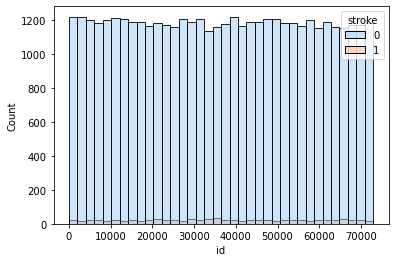

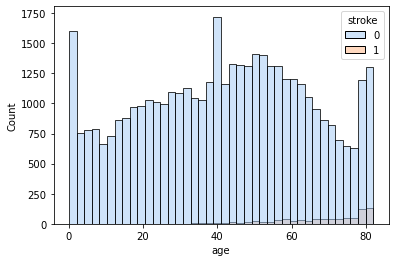

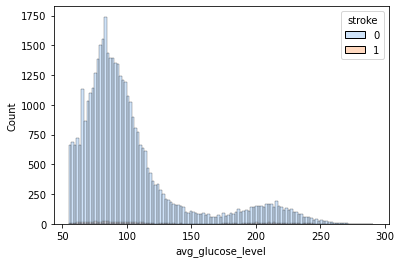

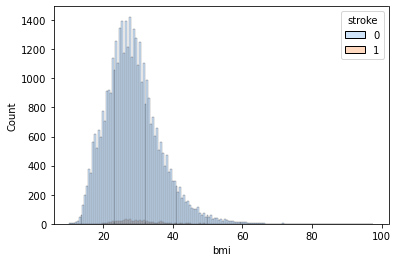

In [10]:
for col in num_cols:
    sns.histplot(x=df[col], data=df, palette="pastel",hue="stroke")
    plt.show(block=True)

### Analyzing Categorical Variables

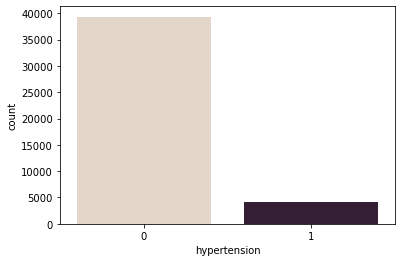

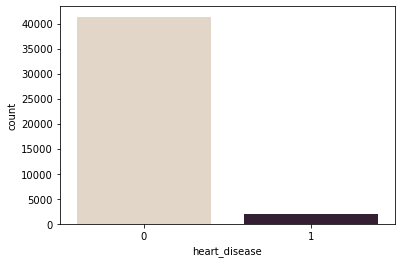

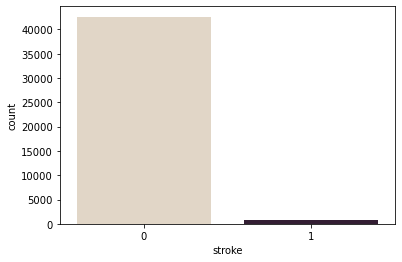

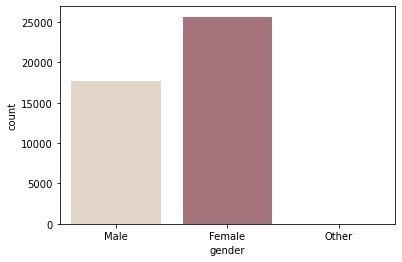

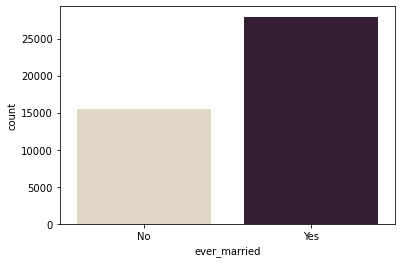

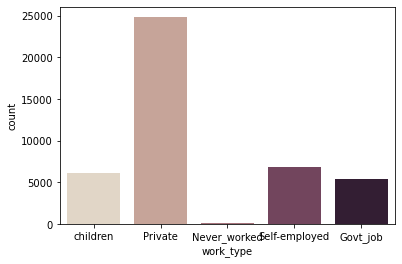

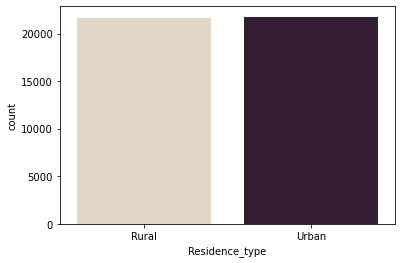

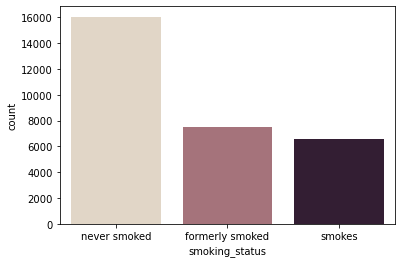

In [11]:
for col in cat_cols: 
    sns.countplot(df[col], palette="ch:.25" )
    plt.show(block=True) 

### Analyzing Target Variable

In [12]:
df["stroke"].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

<AxesSubplot:xlabel='stroke', ylabel='count'>

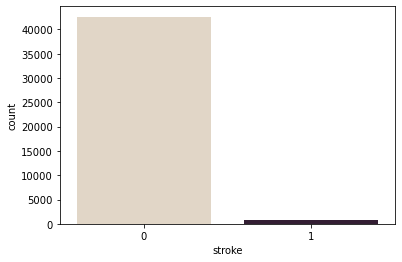

In [13]:
sns.countplot(df["stroke"], palette="ch:.25")

([<matplotlib.patches.Wedge at 0x11663682820>,
 [Text(-1.0982335919159008, 0.06231354256900254, '0'),
  Text(1.2979124229312722, -0.07364334593617207, '1')],
 [Text(-0.5990365046814004, 0.03398920503763774, '98.2%'),
  Text(0.7987153371884752, -0.04531898211456742, '1.8%')])

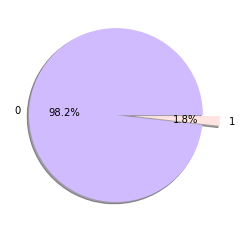

In [14]:
plt.pie(df["stroke"].value_counts(), labels=[0,1], shadow=True, colors=['#d0bbff', "mistyrose"], explode=(0,0.2), autopct="%1.1f%%")

### Checking for Outliers in Numerical Variables

In [15]:
def check_outliers(df, numerical_cols, low_threshold=0.1, up_threshold=0.9):
    outlier_cols = []
    for col in numerical_cols:
        q1 = df[col].quantile(low_threshold)
        q3 = df[col].quantile(up_threshold)
        interquantile = q3 - q1
        up_limit = q3 + 1.5 * interquantile
        low_limit = q1 - 1.5 * interquantile
        if df[(df[col] > up_limit) | (df[col] < low_limit)].any(axis=None):
            outlier_cols.append(col)
    if not outlier_cols:
        print("There is no outliers")
    return outlier_cols

In [16]:
outlier_cols = check_outliers(df, num_cols)

In [17]:
print(outlier_cols)

['bmi']


There are outliers in "bmi"

### Correlation 

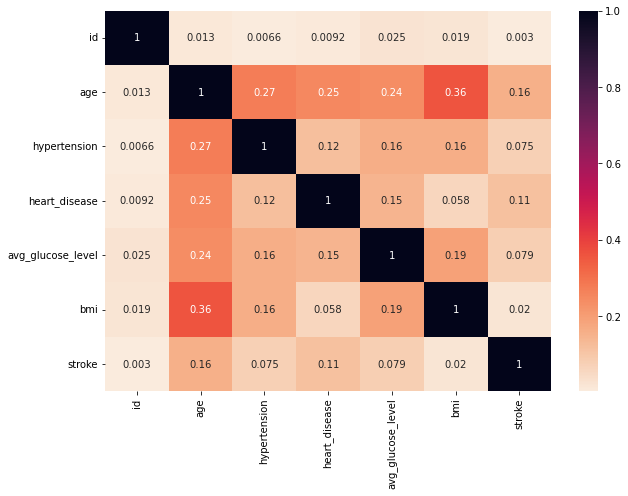

In [18]:
plt.figure(figsize=(10, 7))
correlations = df.corr()
sns.heatmap(correlations, cmap="rocket_r", annot=True)
plt.show()

 There are no highly correlated columns

### Target Variable vs Numerical Columns

In [19]:
for col in num_cols:
    print(df.groupby("stroke").agg({col:"mean"}), end="\n\n")

                  id
stroke              
0       36317.641293
1       36788.836526

              age
stroke           
0       41.741565
1       68.143448

        avg_glucose_level
stroke                   
0              104.021590
1              129.582669

              bmi
stroke           
0       28.585371
1       29.868118



According to the results, the probability of having a stroke increases with age, glucose level and bmi

### Target Variable vs Categorical Columns

In [20]:
for col in cat_cols:
    print(pd.DataFrame({"target_mean": df.groupby(col)["stroke"].mean()}), end="\n\n")

              target_mean
hypertension             
0                0.014820
1                0.049249

               target_mean
heart_disease             
0                 0.014660
1                 0.085839

        target_mean
stroke             
0               0.0
1               1.0

        target_mean
gender             
Female     0.016793
Male       0.019860
Other      0.000000

              target_mean
ever_married             
No               0.005174
Yes              0.025163

               target_mean
work_type                 
Govt_job          0.016360
Never_worked      0.000000
Private           0.017758
Self-employed     0.036950
children          0.000325

                target_mean
Residence_type             
Rural              0.017742
Urban              0.018340

                 target_mean
smoking_status              
formerly smoked     0.029494
never smoked        0.017691
smokes              0.020268



According to the results,

- People with hypertension are more likely to have a stroke
- People with heart disease are more likely to have a stroke
- The probability of having a stroke is the same in men and woman
- People who have been married are more likely to have a stroke
- People who are self-employed are more likely to have a stroke
- The probability of having a stroke is higher in formerly smoked people

## Data Preprocessing & Feature Engineering

### Filling Missing Values

In [21]:
df["bmi"].fillna(df["bmi"].median(),inplace=True)


In [22]:
df['smoking_status'].value_counts()

never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

In [23]:
df['smoking_status'].fillna("never smoked",inplace=True)

In [24]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Label Encoder

In [25]:
#Converting ever_married to numerical 
cleanup_nums={ 'ever_married' : {"No":0,"Yes":1}}
df.replace(cleanup_nums,inplace=True)
df['ever_married'].value_counts()

1    27938
0    15462
Name: ever_married, dtype: int64

In [26]:
#Converting Residence_type to numerical 
cleanup_nums={ 'Residence_type' : {"Rural":0,"Urban":1}}
df.replace(cleanup_nums,inplace=True)
df['Residence_type'].value_counts()

1    21756
0    21644
Name: Residence_type, dtype: int64

### One-Hot Encoder

One-hot encoder was applied to columns with more than 2 categories

In [27]:
# apply one-hot encoding to the categorical data
one_hot = pd.get_dummies(df['gender'])

# add the one-hot encoded data back to the original dataframe
df = df.drop('gender', axis=1)
df = df.join(one_hot)

# print the resulting dataframe
df.head()


,id,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Female,Male,Other
0,30669,3.0,0,0,0,children,0,95.12,18.0,never smoked,0,0,1,0
1,30468,58.0,1,0,1,Private,1,87.96,39.2,never smoked,0,0,1,0
2,16523,8.0,0,0,0,Private,1,110.89,17.6,never smoked,0,1,0,0
3,56543,70.0,0,0,1,Private,0,69.04,35.9,formerly smoked,0,1,0,0
4,46136,14.0,0,0,0,Never_worked,0,161.28,19.1,never smoked,0,0,1,0


In [28]:
# apply one-hot encoding to the categorical data
one_hot = pd.get_dummies(df['work_type'])

# add the one-hot encoded data back to the original dataframe
df = df.drop('work_type', axis=1)
df = df.join(one_hot)

# print the resulting dataframe
df.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Female,Male,Other,Govt_job,Never_worked,Private,Self-employed,children
0,30669,3.0,0,0,0,0,95.12,18.0,never smoked,0,0,1,0,0,0,0,0,1
1,30468,58.0,1,0,1,1,87.96,39.2,never smoked,0,0,1,0,0,0,1,0,0
2,16523,8.0,0,0,0,1,110.89,17.6,never smoked,0,1,0,0,0,0,1,0,0
3,56543,70.0,0,0,1,0,69.04,35.9,formerly smoked,0,1,0,0,0,0,1,0,0
4,46136,14.0,0,0,0,0,161.28,19.1,never smoked,0,0,1,0,0,1,0,0,0


In [29]:
# apply one-hot encoding to the categorical data
one_hot = pd.get_dummies(df['smoking_status'])

# add the one-hot encoded data back to the original dataframe
df = df.drop('smoking_status', axis=1)
df = df.join(one_hot)

# print the resulting dataframe
df.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Female,Male,Other,Govt_job,Never_worked,Private,Self-employed,children,formerly smoked,never smoked,smokes
0,30669,3.0,0,0,0,0,95.12,18.0,0,0,1,0,0,0,0,0,1,0,1,0
1,30468,58.0,1,0,1,1,87.96,39.2,0,0,1,0,0,0,1,0,0,0,1,0
2,16523,8.0,0,0,0,1,110.89,17.6,0,1,0,0,0,0,1,0,0,0,1,0
3,56543,70.0,0,0,1,0,69.04,35.9,0,1,0,0,0,0,1,0,0,1,0,0
4,46136,14.0,0,0,0,0,161.28,19.1,0,0,1,0,0,1,0,0,0,0,1,0


### Dealing with Outliers

 Using the Interquartile Range method, outliers were replaced with their upper and lower limits

In [30]:
def replace_with_thresholds(df, col, low_threshold=0.1, up_threshold=0.9):
    q1 = df[col].quantile(low_threshold)
    q3 = df[col].quantile(up_threshold)
    interquantile = q3 - q1
    up_limit = q3 + 1.5 * interquantile
    low_limit = q1 - 1.5 * interquantile
    df.loc[(df[col] < low_limit), col] = low_limit
    df.loc[(df[col] > up_limit), col] = up_limit

In [31]:
for col in outlier_cols:
    replace_with_thresholds(df, col)

In [32]:
check_outliers(df, num_cols) # Checked for outliers again

There is no outliers


[]

### Feature Scaling

Min-Max Scaler was applied to "age", "bmi" and "avg_glucose_level"

In [33]:
sc = MinMaxScaler()

In [34]:
df["age"] = sc.fit_transform(df[["age"]])
df["bmi"] = sc.fit_transform(df[["bmi"]])
df["avg_glucose_level"] = sc.fit_transform(df[["avg_glucose_level"]])

In [35]:
df.head()

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,Female,Male,Other,Govt_job,Never_worked,Private,Self-employed,children,formerly smoked,never smoked,smokes
0,30669,0.035645,0,0,0,0,0.169964,0.139453,0,0,1,0,0,0,0,0,1,0,1,0
1,30468,0.707031,1,0,1,1,0.139631,0.513680,0,0,1,0,0,0,1,0,0,0,1,0
2,16523,0.096680,0,0,0,1,0.236772,0.132392,0,1,0,0,0,0,1,0,0,0,1,0
3,56543,0.853516,0,0,1,0,0.059479,0.455428,0,1,0,0,0,0,1,0,0,1,0,0
4,46136,0.169922,0,0,0,0,0.450244,0.158870,0,0,1,0,0,1,0,0,0,0,1,0


# Model Building

## SMOTE

In [36]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
y = df["stroke"]
X = df.drop(["stroke", "id"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
sum(y_train == 1)


618

There are 626 data equal to 1

In [38]:
sum(y_train == 0)

34102

There are 34094 data equal to 0

In [39]:
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [40]:
sum(y_train_smote == 1)

34102

There are 34094 data equal to 1

In [41]:
sum(y_train_smote == 0)

34102

There are 34094 data equal to 0


## Logistic Regression

In [42]:
logreg = LogisticRegression()   #build our logistic model
logreg.fit(X_train_smote, y_train_smote)  #fitting training data
y_pred  = logreg.predict(X_test)  
print("Accuracy={:.2f}".format(logreg.score(X_test, y_test)))

Accuracy=0.75


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

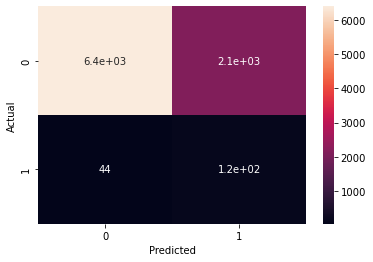

In [43]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

## KNN

In [44]:
knn=KNeighborsClassifier(n_neighbors=20) #build our knn classifier
knn.fit(X_train_smote,y_train_smote) #Training KNN classifier
y_pred=knn.predict(X_test) #Testing
print('Accuracy=',accuracy_score(y_pred,y_test))

Accuracy= 0.803110599078341


In [45]:
n_neighbors=30
scores=[]
for k in range(1,30):
    knn=KNeighborsClassifier(n_neighbors-k)
    knn.fit(X_train_smote,y_train_smote)
    y_pred=knn.predict(X_test)
    print('Accuracy for k=',k,'is:',round(accuracy_score(y_pred,y_test),2))
    scores.append(round(accuracy_score(y_pred,y_test),2))

Accuracy for k= 1 is: 0.78
Accuracy for k= 2 is: 0.79
Accuracy for k= 3 is: 0.78
Accuracy for k= 4 is: 0.79
Accuracy for k= 5 is: 0.78
Accuracy for k= 6 is: 0.8
Accuracy for k= 7 is: 0.79
Accuracy for k= 8 is: 0.8
Accuracy for k= 9 is: 0.79
Accuracy for k= 10 is: 0.8
Accuracy for k= 11 is: 0.8
Accuracy for k= 12 is: 0.81
Accuracy for k= 13 is: 0.8
Accuracy for k= 14 is: 0.81
Accuracy for k= 15 is: 0.81
Accuracy for k= 16 is: 0.82
Accuracy for k= 17 is: 0.81
Accuracy for k= 18 is: 0.83
Accuracy for k= 19 is: 0.82
Accuracy for k= 20 is: 0.84
Accuracy for k= 21 is: 0.83
Accuracy for k= 22 is: 0.85
Accuracy for k= 23 is: 0.84
Accuracy for k= 24 is: 0.86
Accuracy for k= 25 is: 0.85
Accuracy for k= 26 is: 0.88
Accuracy for k= 27 is: 0.87
Accuracy for k= 28 is: 0.91
Accuracy for k= 29 is: 0.9


Text(0, 0.5, 'Testing Accuracy')

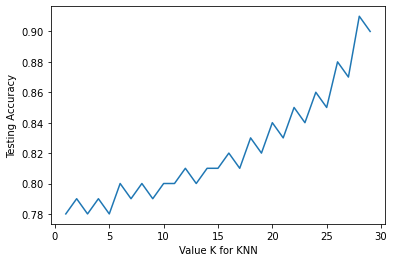

In [46]:
import matplotlib.pyplot as plt
plt.plot(range(1,30),scores)
plt.xlabel('Value K for KNN')
plt.ylabel('Testing Accuracy')

the best k is 28


In [47]:
knn=KNeighborsClassifier(n_neighbors=2) #build our knn classifier
knn.fit(X_train_smote,y_train_smote) #Training KNN classifier
y_pred=knn.predict(X_test) #Testing
print('Accuracy=',accuracy_score(y_pred,y_test))

Accuracy= 0.9126728110599078


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

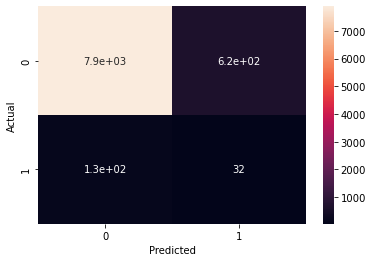

In [48]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

## DecisionTree

In [49]:
from sklearn import tree   
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

SEED=15

#applying tree algorithm
model = tree.DecisionTreeClassifier(random_state=SEED)

model.fit(X_train_smote, y_train_smote)   #fitting our model
y_pred=model.predict(X_test)   # evaluating our model

print("score:{}".format(accuracy_score(y_test, y_pred)))

score:0.9517281105990784


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

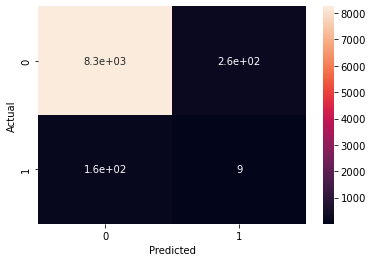

In [50]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

## Random forest 


In [51]:
from sklearn import metrics

clf=RandomForestClassifier(n_estimators=10)  #Creating a random forest with n decision trees
clf.fit(X_train_smote, y_train_smote)  #Training our model
y_pred=clf.predict(X_test)  #testing our model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))  #Measuring the accuracy of our model


Accuracy: 0.9282258064516129


In [52]:
from sklearn import metrics

clf=RandomForestClassifier(n_estimators=50)  #Creating a random forest with n decision trees
clf.fit(X_train_smote, y_train_smote)  #Training our model
y_pred=clf.predict(X_test)  #testing our model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))  #Measuring the accuracy of our model

Accuracy: 0.9237327188940092


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

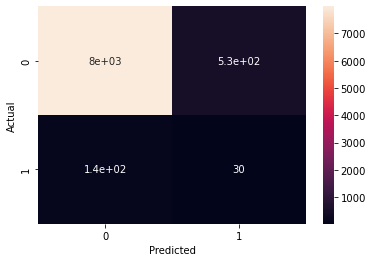

In [53]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

### XGBOOST


In [54]:
# Create XGBoost model
xgb_model = XGBClassifier()

# Fit the model to the training data
xgb_model.fit(X_train_smote, y_train_smote)

# Make predictions on the testing data
y_pred = xgb_model.predict(X_test)

# Evaluate model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.98%


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

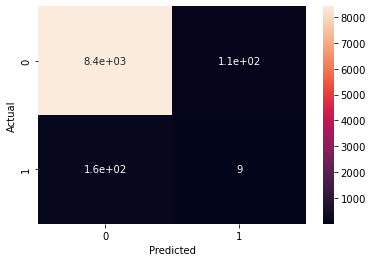

In [55]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

### GradientBoost


In [56]:
# Create a GBM model
gbm = GradientBoostingClassifier()

# Train the model on the training set
gbm.fit(X_train_smote,y_train_smote)

# Make predictions on the test set
y_pred = gbm.predict(X_test)

# Evaluate the performance of the model

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.06%


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

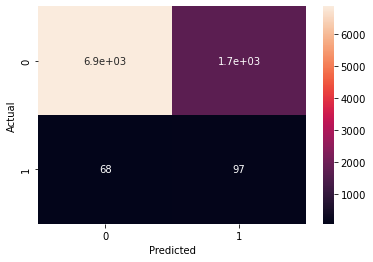

In [57]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [ ]:
df.head()